![Logo ONCFM](./logo.png)

# Contexte du projet
L’Organisation nationale de lutte contre le faux-monnayage (ONCFM) est
une organisation publique ayant pour objectif de mettre en place des
méthodes d’identification des contrefaçons des billets en euros. Dans le
cadre de cette lutte, nous souhaitons mettre en place un algorithme qui
soit capable de différencier automatiquement les vrais des faux billets

# 1. Préparation de l'environnement de travail

In [1]:
#Installation des librairies
import subprocess
import sys

def install_requirements():
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])

install_requirements()

In [ ]:
#Imporation des librairies
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.api as sms
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import joblib

In [ ]:
# Définir un style de base pour matplotlib
plt.style.use('seaborn-darkgrid')

# Palette personnalisée
custom_colors = ['#2B5B80', '#FF6F61']

# Configurer seaborn avec la palette et le style choisi
sns.set(
    style="whitegrid",
    palette=sns.color_palette(custom_colors),
    context="notebook"
)

## Chargement et exploration des données

In [2]:
data = pd.read_csv("./12/billets.csv", sep=";")

In [3]:
# afficher les premieres lignes de notre dataframe
display(data.head())

# afficher les informations du dataframe
display(data.info())

# afficher les statiques descriptives du dataframe
display(data.describe())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


None

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [4]:
# Verifier les valeurs manquantes :
display(data.isna().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [5]:
display(data['is_genuine'].value_counts())

is_genuine
True     1000
False     500
Name: count, dtype: int64

In [6]:
palette = {
    False: '#FF6F61',
    True: '#2B5B80'
}

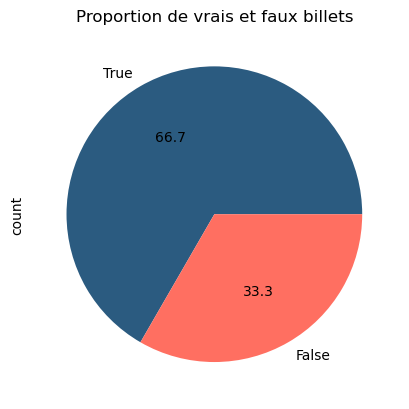

In [7]:
data['is_genuine'].value_counts().plot.pie(autopct='%.1f', colors = ['#2B5B80','#FF6F61'])
plt.title('Proportion de vrais et faux billets')
plt.show()

## Distribution des données

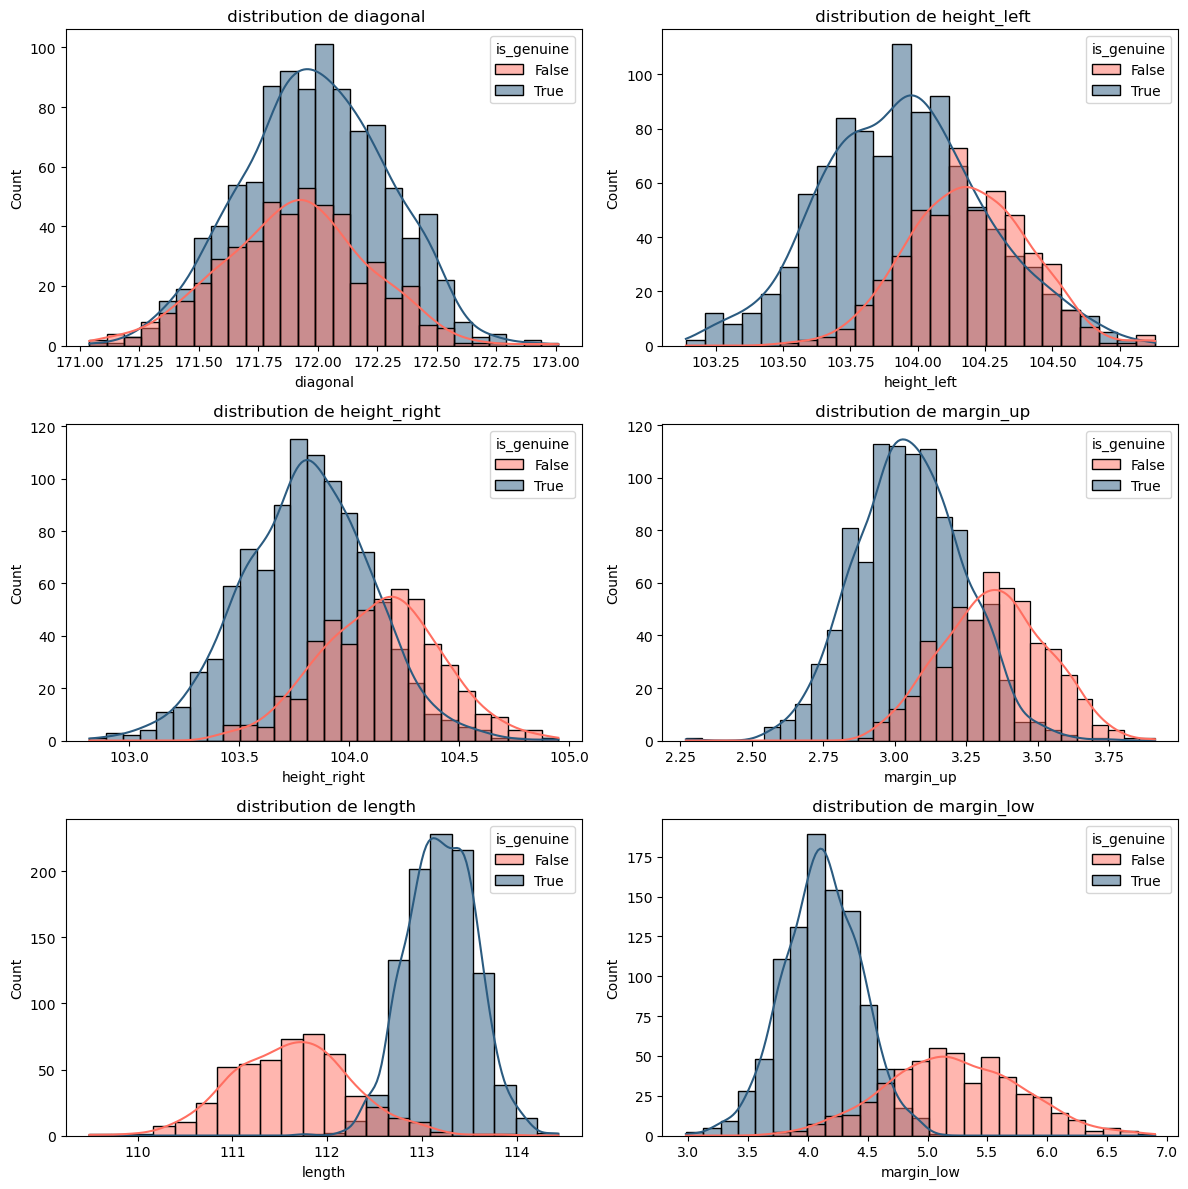

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()
variables = ['diagonal', 'height_left','height_right','margin_up','length','margin_low']

for i, variable in enumerate(variables):
    sns.histplot(data, x=variable,kde=True, ax=axes[i], hue ="is_genuine", palette = palette)
    axes[i].set_title(f" distribution de {variable}")

plt.tight_layout()
plt.show()

## Corrélation entre les variables

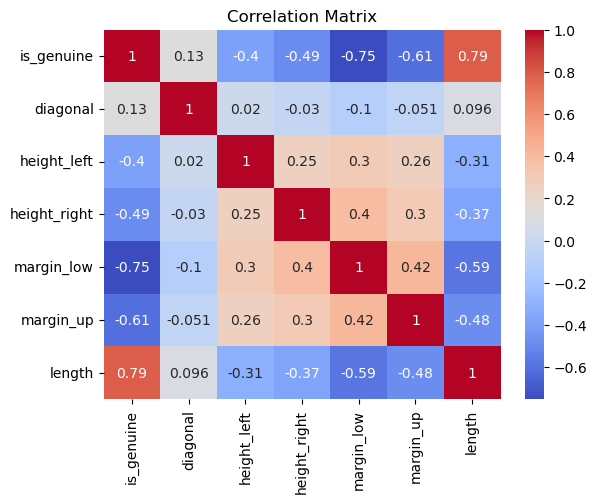

In [9]:
data_corr = data.corr('spearman')
sns.heatmap(data_corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 2. Prétraitement des données

## Normalisation des données

In [10]:
# On commence par créer  un dataframe sans "is_genuine"
data_to_scale = data.drop(columns=['is_genuine'])

# Initialisation du standarscaler
scaler = StandardScaler()

# On applique le standarscaler
scaled_data = scaler.fit_transform(data_to_scale)

# Convertir les données normalisées en dataframe tout en réintegrant la colonne "is_genuine"
data_scaled = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
data_scaled['is_genuine'] = data['is_genuine'].values

## Visuel Relation entre les variablies 

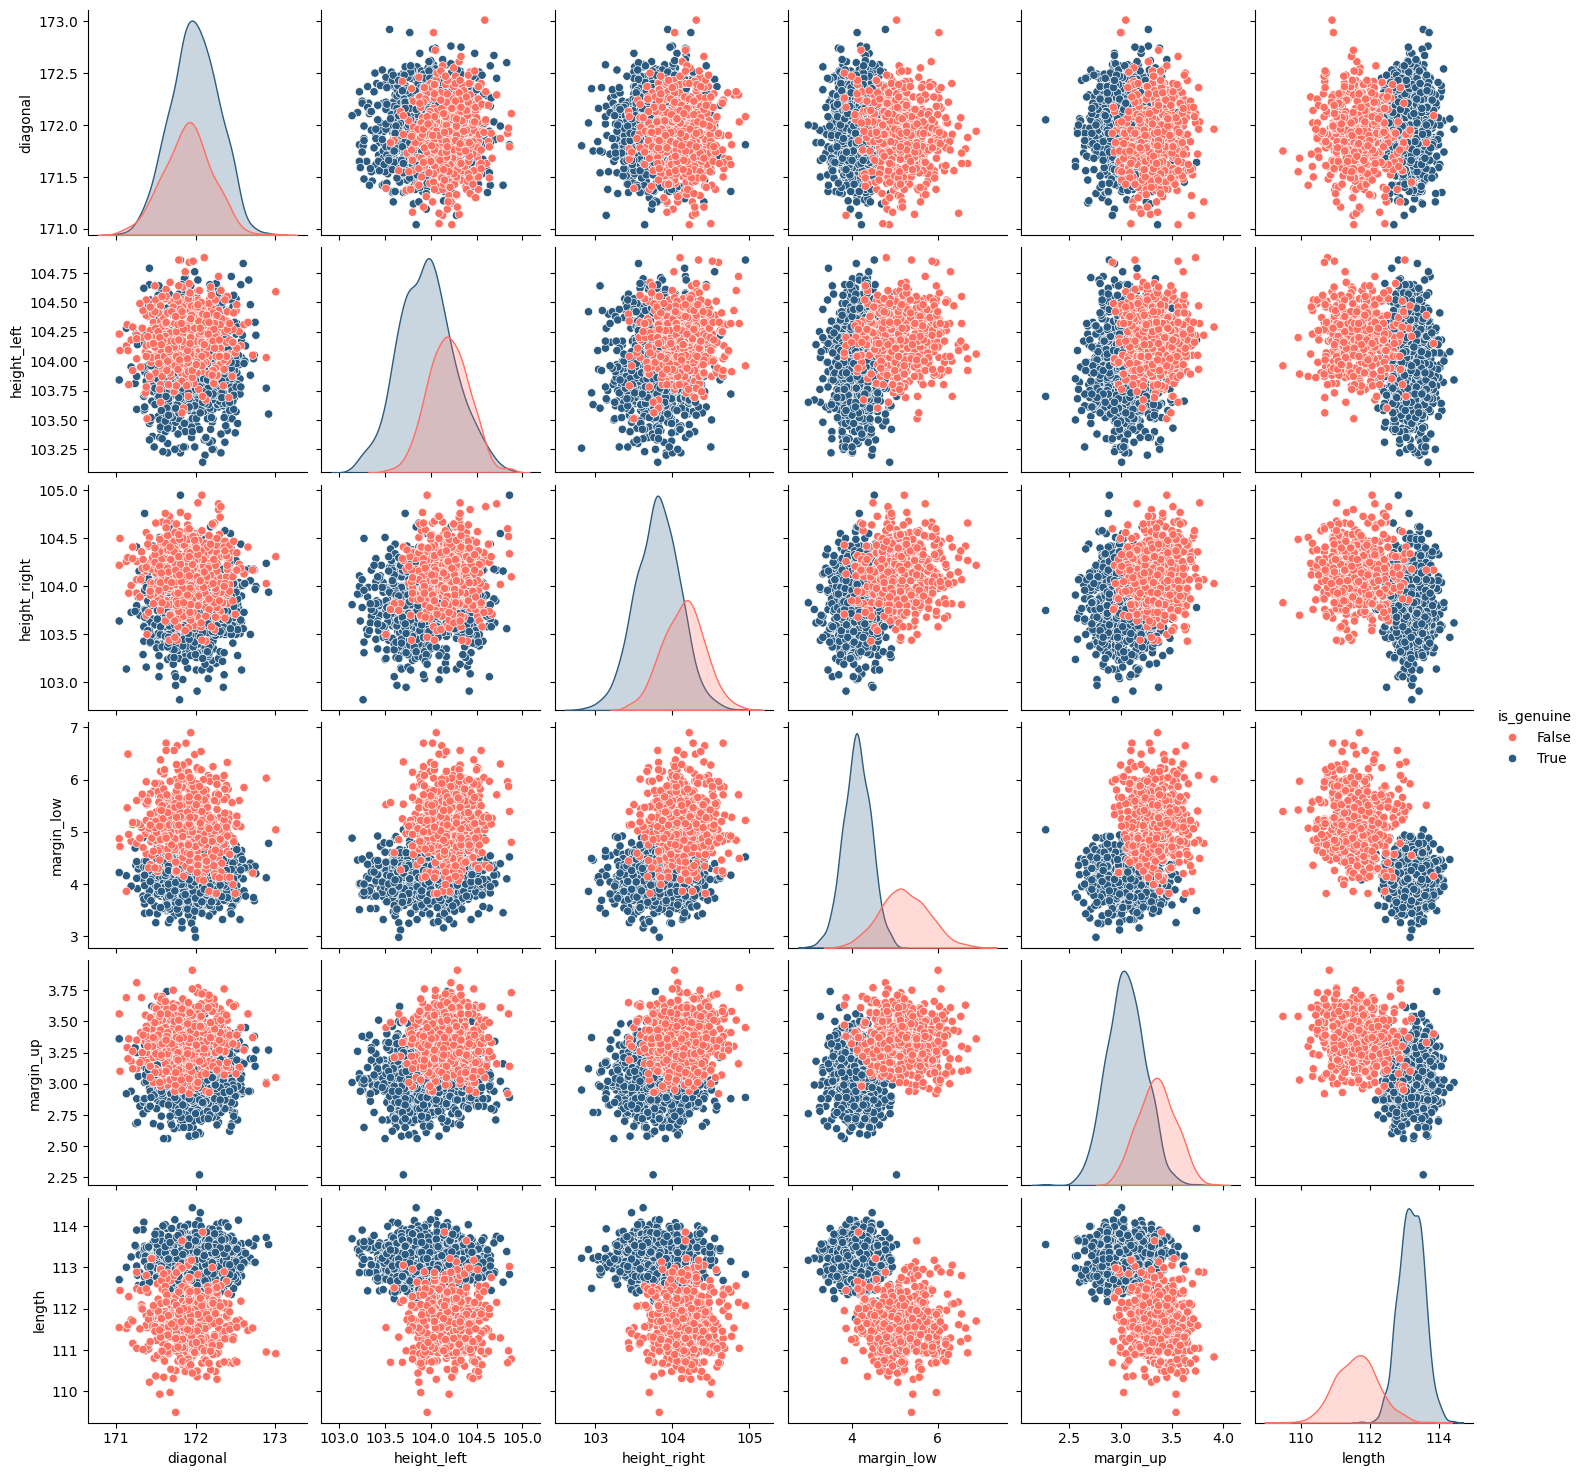

In [11]:
sns.pairplot(data, hue = "is_genuine", palette= palette)

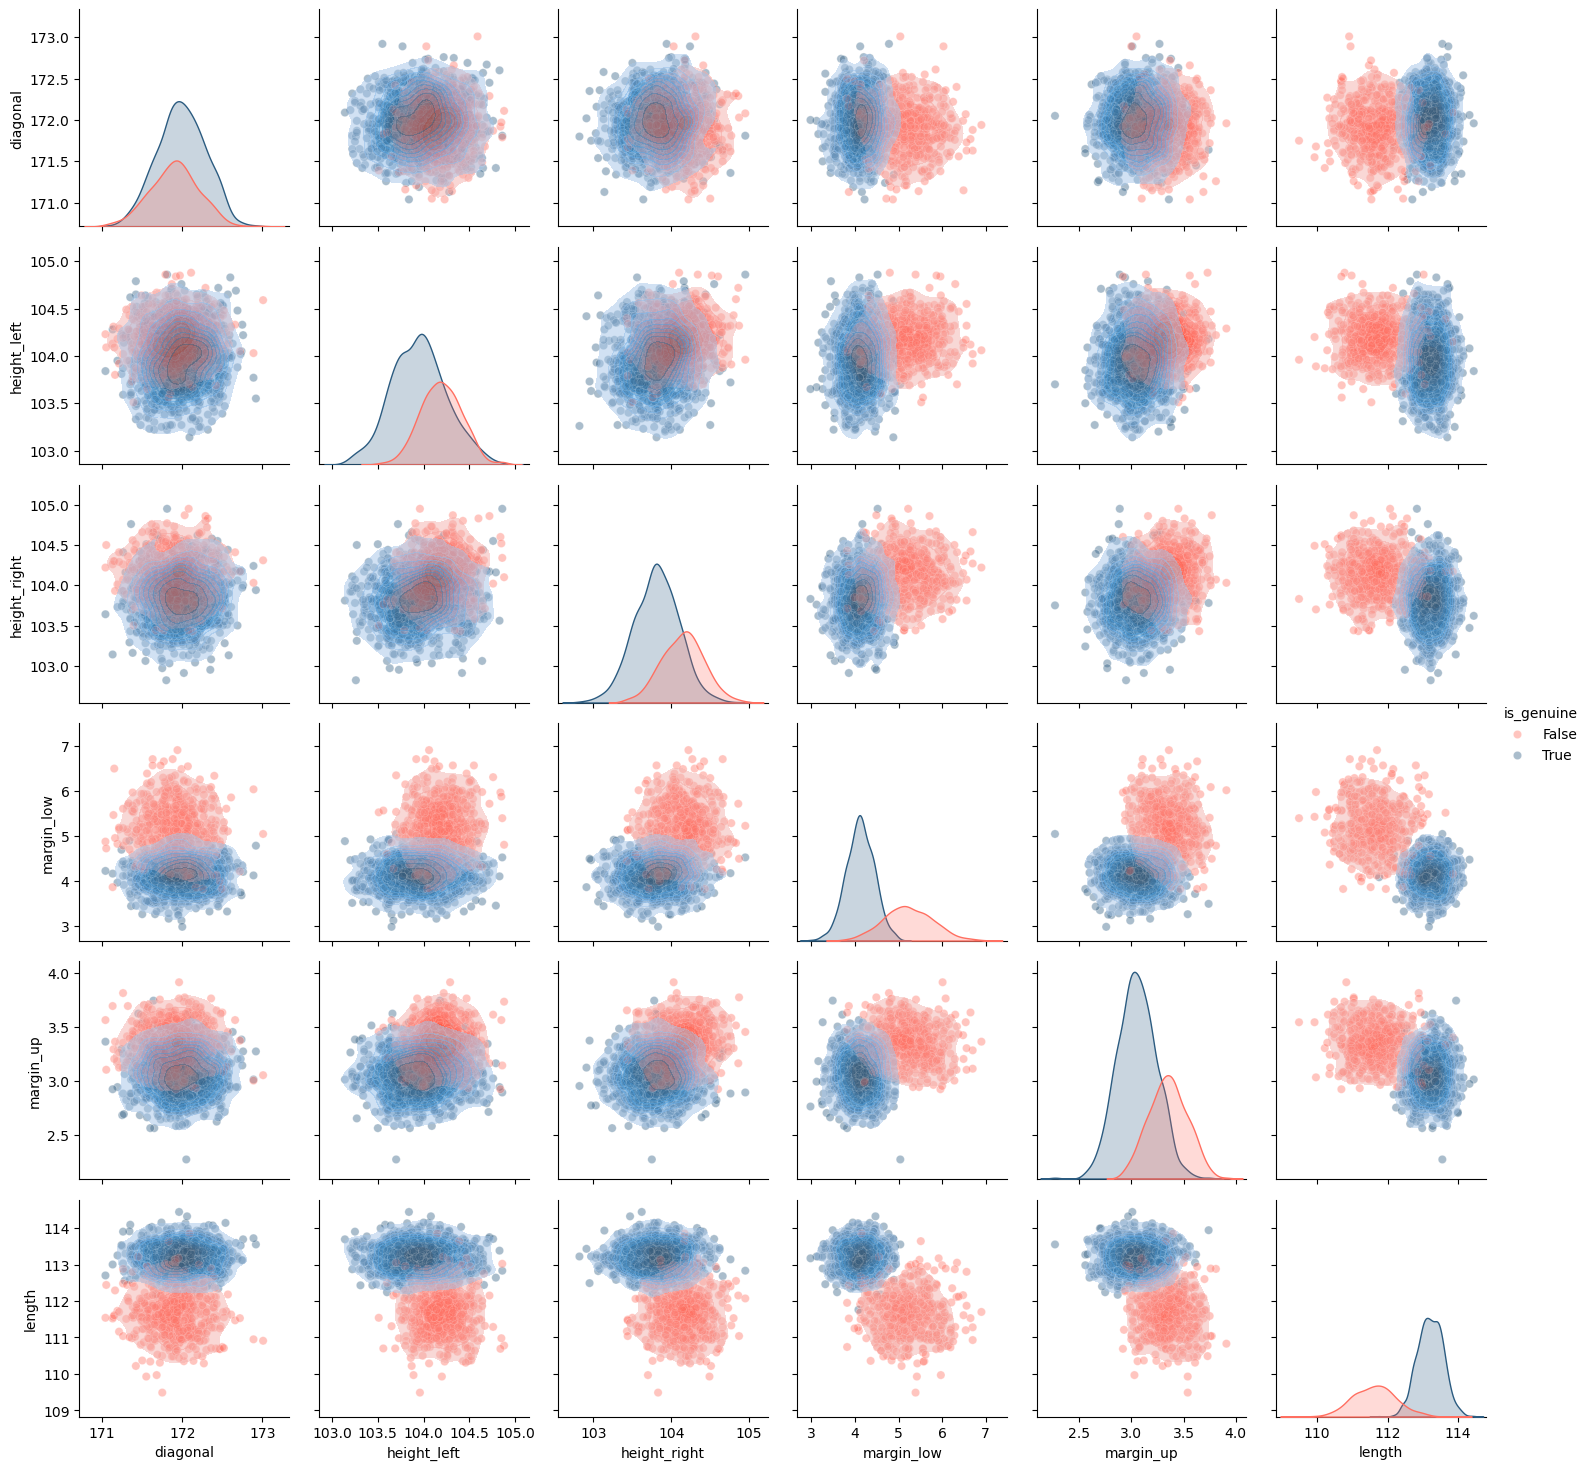

In [12]:
# Créer un PairGrid pour plus de personnalisation
g = sns.PairGrid(data, hue='is_genuine', palette= palette)

# Superposer les nuages de points avec une densité KDE pour exprimer la densité
g.map_offdiag(sns.scatterplot, alpha=0.4)
g.map_offdiag(sns.kdeplot, cmap='Reds', fill=True, alpha=0.5)

# Utiliser KDE sur la diagonale pour représenter la densité individuelle
g.map_diag(sns.kdeplot, fill=True)


g.add_legend()
plt.show()

## Traitement des données manquantes

### Mise en place de regression linéaire

In [13]:
#séparer les données vides et les données non vides
df_complete = data_scaled.dropna(subset=['margin_low'])
df_missing = data_scaled[data_scaled['margin_low'].isnull()]

#### Optimisation de la regression linéaire (trouver les meilleurs paramètres)

In [14]:
# On commence par toutes les colonnes disponibles 
remaining = set(['diagonal', 'is_genuine', 'height_left', 'height_right', 'margin_up', 'length'])
response = 'margin_low'
cond = True

# Boucle jusqu'a p-value < 0.05
while remaining and cond:
    # Crée la fromule de regression :
    formula = "{} ~ {} + 1".format(response, '+'.join(remaining))
    print('_____________________________________________________________')
    print(formula)
    print('_____________________________________________________________')

    # Ajuste le modéle :
    model = smf.ols(formula=formula, data=df_complete).fit()

    # Obtenir les p-values (sauf pour l'intercept)
    pvalues = model.pvalues[1:]
    to_remove = pvalues.idxmax()
    max_pvalue = pvalues.max()

    # Retirer la variable la moins significative
    if max_pvalue > 0.05:
        remaining.remove(to_remove)
        print(f"Removing {to_remove} (p-value = {max_pvalue})")
    else :
        cond = False
        print(f"Retenu {to_remove} (p-value = {max_pvalue})")
        print(f"Final model !!!")
    print (model.summary())

_____________________________________________________________
margin_low ~ height_left+length+diagonal+height_right+margin_up+is_genuine + 1
_____________________________________________________________
Removing length (p-value = 0.8684506945585408)
                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Fri, 25 Oct 2024   Prob (F-statistic):          4.75e-299
Time:                        19:24:08   Log-Likelihood:                -1374.1
No. Observations:                1463   AIC:                             2762.
Df Residuals:                    1456   BIC:                             2799.
Df Model:                           6                                         
Covariance Type:            nonrobust  

#### Définir les variables X et Y

In [15]:
# Définir X et Y
X = df_complete[list(remaining)]  # On utilise uniquement les colonnes restantes après l'élimination
Y = df_complete[response]          # 

In [16]:
print(X)

      margin_up  is_genuine
0     -1.128325        True
1     -0.696799        True
2     -0.912562        True
3     -0.610494        True
4      1.417677        True
...         ...         ...
1495  -0.265273       False
1496   0.942999       False
1497   0.899846       False
1498   1.331372       False
1499   0.942999       False

[1463 rows x 2 columns]


In [17]:
# Diviser les données en jeu d'entraînement (70%) et jeu de test (30%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

In [18]:
# Ajuster le modèle de régression linéaire sur le jeu d'entraînement
regression = smf.ols(formula=formula, data=pd.concat([X_train, Y_train], axis=1)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Fri, 25 Oct 2024   Prob (F-statistic):          1.24e-304
Time:                        19:24:08   Log-Likelihood:                -1374.7
No. Observations:                1463   AIC:                             2755.
Df Residuals:                    1460   BIC:                             2771.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.1639      0

# 3. Vérification des Conditions pour la Régression Linéaire

## Linéarité

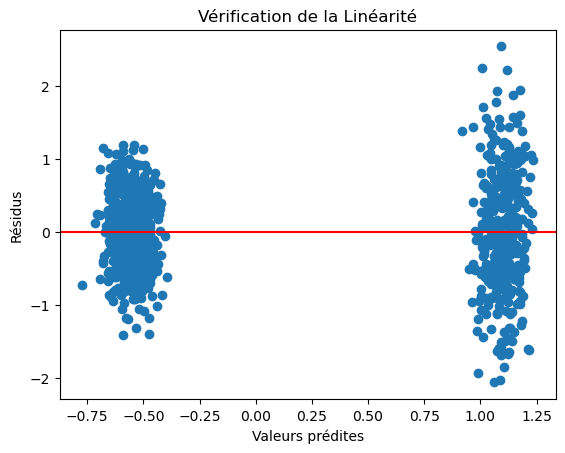

In [19]:
plt.scatter(regression.fittedvalues, regression.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Vérification de la Linéarité')
plt.show()

## Indépendance des Erreurs

In [20]:


dw = durbin_watson(regression.resid)
print(f'Statistique de Durbin-Watson : {dw}')

Statistique de Durbin-Watson : 2.0052889615102587


## Homoscedasticité

In [21]:


test = sms.het_breuschpagan(regression.resid, regression.model.exog)
print(f'P-value du test de Breusch-Pagan : {test[1]}')

P-value du test de Breusch-Pagan : 6.236599338550454e-28


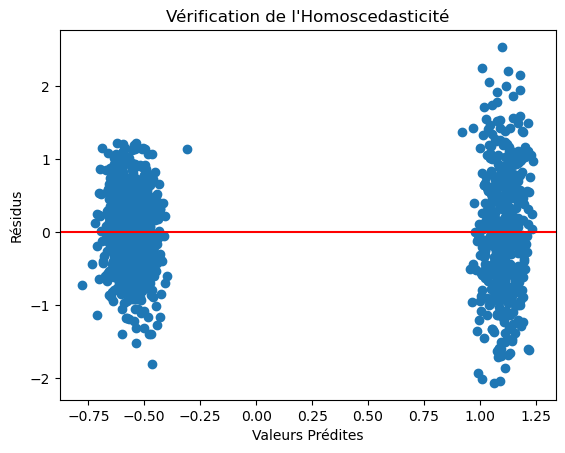

In [22]:
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')
plt.title('Vérification de l\'Homoscedasticité')
plt.show()

## Normalité des Résidus

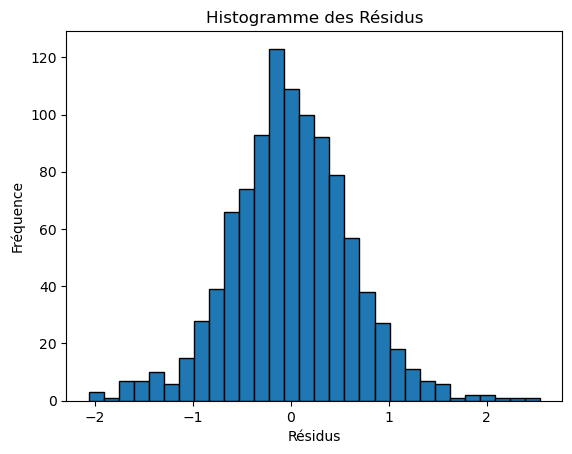

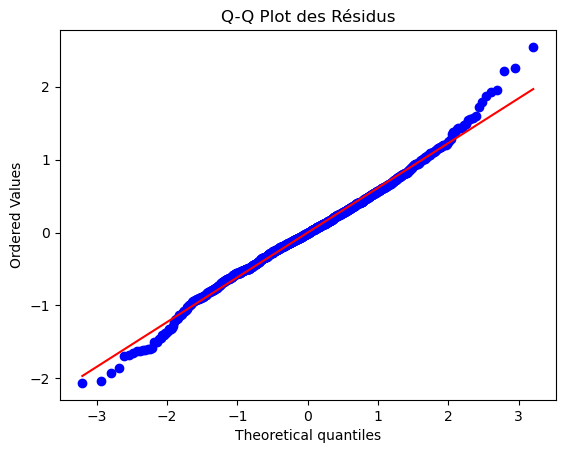

In [23]:

plt.hist(regression.resid, bins=30, edgecolor='k')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Histogramme des Résidus')
plt.show()

stats.probplot(regression.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot des Résidus')
plt.show()

## Absence de Multicolinéarité

In [24]:


X = regression.model.exog
vif_data = pd.DataFrame()
vif_data["feature"] = regression.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif_data)

              feature       VIF
0           Intercept  4.119277
1  is_genuine[T.True]  1.628768
2           margin_up  1.628768


## Évaluation sur le Jeu de Test

In [25]:
Y_pred = regression.predict(X_test)

In [26]:
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f'Erreur Quadratique Moyenne (MSE) : {mse}')
print(f'Coefficient de Détermination (R²) : {r2}')

Erreur Quadratique Moyenne (MSE) : 0.39663637983548916
Coefficient de Détermination (R²) : 0.6049282842779788


## Verifications des données aprés regression linéaire

In [27]:
# Prédire les valeurs manquantes
X_missing = df_missing[['margin_up','is_genuine']]
predicted_margin_low = regression.predict(X_missing)
data_clean = data.copy()
data_clean.loc[data_clean['margin_low'].isnull(), 'margin_low'] = predicted_margin_low

In [28]:
data_clean['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

### Verification des resultats

In [29]:
describe_data = data.groupby('is_genuine').agg(lambda x: x.mean(skipna=True) if x.dtype in ['float64', 'int64'] else None)
describe_data = describe_data.round(2)
print(describe_data)

            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False         171.90       104.19        104.14        5.22       3.35  111.63
True          171.99       103.95        103.81        4.12       3.05  113.20


In [30]:
describe_data_clean = data_clean.groupby('is_genuine').agg(lambda x: x.mean(skipna=True) if x.dtype in ['float64', 'int64'] else None)
describe_data_clean = describe_data_clean.round(2)
print(describe_data_clean)

            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False         171.90       104.19        104.14        5.15       3.35  111.63
True          171.99       103.95        103.81        3.98       3.05  113.20


# Création des MMLs

## Préparation des données

### Division des données en ensemble d'entraînement et de test

In [31]:
# Définir les caractéristiques
X = data_clean.drop('is_genuine', axis=1)

# Définir la cible
y = data_clean['is_genuine']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y, shuffle=True)

In [33]:
print("Dimensions de X :", X.shape)
print("Dimensions de X_train :", X_train.shape)
print("Dimensions de X_test :", X_test.shape)

Dimensions de X : (1500, 6)
Dimensions de X_train : (1200, 6)
Dimensions de X_test : (300, 6)


### Normalisation des données

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Mise en place des modèles de machine learning non supervisés

### 1. Kmeans

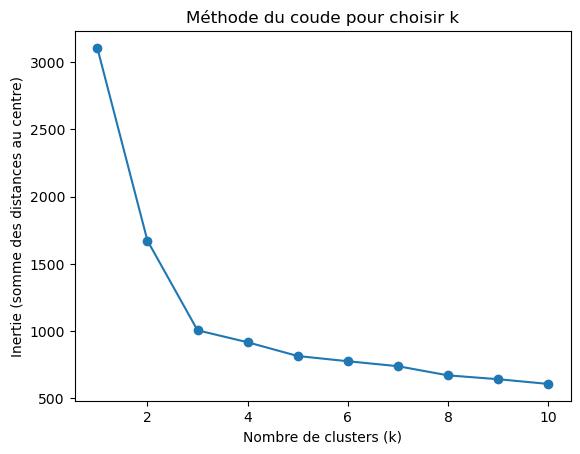

In [36]:
inertias = []
k_values = range(1, 11)  # Tester de 1 à 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=7)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Tracer le graphique pour visualiser le "coude"
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (somme des distances au centre)')
plt.title('Méthode du coude pour choisir k')
plt.show()

In [37]:
# Initialiser KMeans avec le nombre de clusters choisi
kmeans = KMeans(n_clusters=2, random_state=7) 
kmeans.fit(X_train_scaled)
y_pred_kmeans = kmeans.predict(X_test_scaled)

In [38]:

# Mapper les clusters aux labels majoritaires
train_clusters = kmeans.labels_
cluster_labels = {cluster: y_train.iloc[np.where(train_clusters == cluster)].mode()[0]
                  for cluster in np.unique(train_clusters)}

# Mapper les clusters prédits aux labels réels
y_pred_kmeans_mapped = [cluster_labels[cluster] for cluster in y_pred_kmeans]

In [39]:
# Calculer l'exactitude
accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans_mapped)
print("Exactitude du K-means :", accuracy_kmeans)

# Afficher la matrice de confusion
cm_kmeans = confusion_matrix(y_test, y_pred_kmeans_mapped)
print("Matrice de confusion :\n", cm_kmeans)

# Afficher le rapport de classification
cr_kmeans = classification_report(y_test, y_pred_kmeans_mapped)
print("Rapport de classification :\n", cr_kmeans)

Exactitude du K-means : 0.9733333333333334
Matrice de confusion :
 [[ 97   3]
 [  5 195]]
Rapport de classification :
               precision    recall  f1-score   support

       False       0.95      0.97      0.96       100
        True       0.98      0.97      0.98       200

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



## Mise en place des modèles de machine learning supervisés

### 1. Régression logistique

In [40]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
# Lancer la prédiction
y_pred_logreg = logreg.predict(X_test_scaled)

In [41]:
#Calculer l'exactitude
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Exactitude de la régression logistique :", accuracy_logreg)

Exactitude de la régression logistique : 0.9833333333333333


In [42]:
#Afficher la matrice de confusion
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Matrice de confusion :\n", cm_logreg)

Matrice de confusion :
 [[ 96   4]
 [  1 199]]


In [43]:
#rapport de classification
cr_logreg = classification_report(y_test, y_pred_logreg)
print("Rapport de classification :\n", cr_logreg)

Rapport de classification :
               precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [44]:
# Probabilité d'appartenance à la classe positive
y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

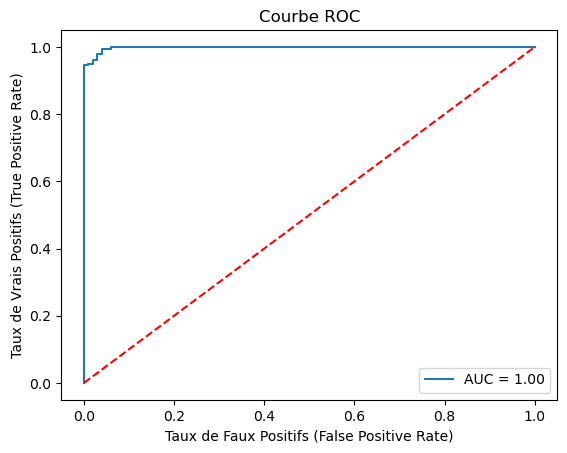

In [45]:


# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
auc = roc_auc_score(y_test, y_prob_logreg)

# Tracer la courbe ROC
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Ligne de hasard
plt.xlabel('Taux de Faux Positifs (False Positive Rate)')
plt.ylabel('Taux de Vrais Positifs (True Positive Rate)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

#### Approche avec cross-validation

In [46]:


# Configurer le pipeline
pipeline_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Effectuer la validation croisée avec scaling
scores_logreg = cross_val_score(pipeline_logreg, X, y, cv=3)

# Afficher les scores
print("Scores pour chaque pli :", scores_logreg)
print("Score moyen :", scores_logreg.mean())

Scores pour chaque pli : [0.978 0.984 0.984]
Score moyen : 0.9819999999999999


### 2. KNN (K-Nearest Neighbors)

Meilleur nombre de voisins k : 4


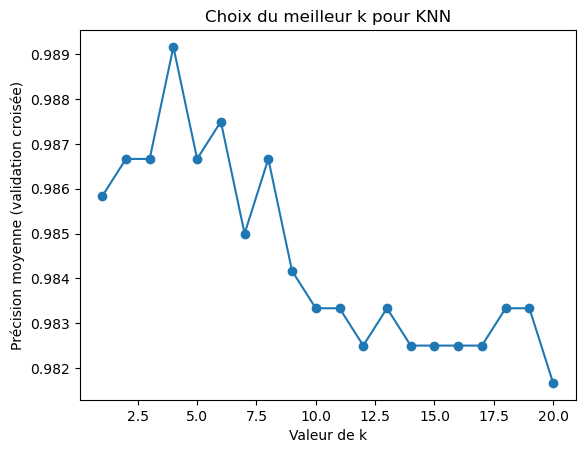

In [47]:
# Tester différentes valeurs de k
k_values = range(1, 21)  # Tester k de 1 à 20
cv_scores = []           # Pour stocker les scores de validation croisée



for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

# Trouver la meilleure valeur de k
best_k = k_values[cv_scores.index(max(cv_scores))]
print("Meilleur nombre de voisins k :", best_k)

# Tracer les scores pour chaque k
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Valeur de k')
plt.ylabel('Précision moyenne (validation croisée)')
plt.title("Choix du meilleur k pour KNN")
plt.show()

In [48]:
# Initialiser et entraîner le modèle KNN avec le meilleur k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# Prédire les classes pour l'ensemble de test
y_pred_knn = knn.predict(X_test_scaled)

# Évaluer les performances
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Exactitude du modèle KNN avec le meilleur k :", accuracy_knn)

cm_knn = confusion_matrix(y_test, y_pred_knn)
print("Matrice de confusion :\n", cm_knn)

cr_knn = classification_report(y_test, y_pred_knn)
print("Rapport de classification :\n", cr_knn)

Exactitude du modèle KNN avec le meilleur k : 0.9833333333333333
Matrice de confusion :
 [[ 96   4]
 [  1 199]]
Rapport de classification :
               precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [49]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


#### Avec Pipeline et GridSearchCV

In [50]:


# Définir la grille de valeurs pour k
param_grid_knn = {'knn__n_neighbors': range(1, 21)}  # Tester de k=1 à k=20

# Utiliser GridSearchCV pour trouver le meilleur k
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Meilleur k trouvé
best_k = grid_search_knn.best_params_['knn__n_neighbors']
print("Meilleur nombre de voisins k :", best_k)
print("Meilleure précision obtenue :", grid_search_knn.best_score_)


Meilleur nombre de voisins k : 4
Meilleure précision obtenue : 0.9883333333333333


In [51]:
# Prédire les classes pour l'ensemble de test avec le modèle optimisé
y_pred_knn = grid_search_knn.best_estimator_.predict(X_test)

# Évaluer les performances
accuracy = accuracy_score(y_test, y_pred_knn)
print("Exactitude du modèle KNN avec le meilleur k :", accuracy)

cm = confusion_matrix(y_test, y_pred_knn)
print("Matrice de confusion :\n", cm)

cr = classification_report(y_test, y_pred_knn)
print("Rapport de classification :\n", cr)


Exactitude du modèle KNN avec le meilleur k : 0.9833333333333333
Matrice de confusion :
 [[ 96   4]
 [  1 199]]
Rapport de classification :
               precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



### 3. SVM

In [52]:


# Pipeline pour scaling et SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

# Définir la grille de paramètres
param_grid_svm = {
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto']  # Pour les kernels rbf, poly, sigmoid
}

# GridSearchCV pour trouver le meilleur kernel et les hyperparamètres
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=3, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

# Meilleur kernel et hyperparamètres
print("Meilleur kernel et hyperparamètres :", grid_search_svm.best_params_)
print("Meilleure précision :", grid_search_svm.best_score_)


Meilleur kernel et hyperparamètres : {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Meilleure précision : 0.9916666666666666


In [ ]:
# Prédire les classes pour l'ensemble de test avec le modèle optimisé
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test)

# Évaluer les performances
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Exactitude du modèle SVM:", accuracy_svm)

cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Matrice de confusion :\n", cm_svm)

cr_svm = classification_report(y_test, y_pred_svm)
print("Rapport de classification :\n", cr_svm)

Exactitude du modèle SVM: 0.9866666666666667
Matrice de confusion :
 [[ 96   4]
 [  0 200]]
Rapport de classification :
               precision    recall  f1-score   support

       False       1.00      0.96      0.98       100
        True       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



### 4. Random Forest

Bien que Random Forest ne nécessite pas de scaling (puisque les arbres de décision sont basés sur des seuils), il est souvent pratique de scaler les données pour maintenir la cohérence avec d'autres modèles.

In [54]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=7)

rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=7)

In [55]:
# Prédire les classes pour l'ensemble de test
y_pred_rf = rf_model.predict(X_test_scaled)

# Évaluer les performances
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Exactitude du modèle Random Forest :", accuracy_rf)

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Matrice de confusion :\n", cm_rf)

cr_rf = classification_report(y_test, y_pred_rf)
print("Rapport de classification :\n", cr_rf)


Exactitude du modèle Random Forest : 0.9866666666666667
Matrice de confusion :
 [[ 96   4]
 [  0 200]]
Rapport de classification :
               precision    recall  f1-score   support

       False       1.00      0.96      0.98       100
        True       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



Optimisation :

In [56]:
# Définir la grille de paramètres
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=7),
                              param_grid=param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

# Meilleurs paramètres trouvés
print("Meilleurs hyperparamètres :", grid_search_rf.best_params_)
print("Meilleure précision obtenue :", grid_search_rf.best_score_)


Meilleurs hyperparamètres : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Meilleure précision obtenue : 0.9925


In [57]:
# Prédire avec le modèle optimisé
y_pred_rf_optimized = grid_search_rf.best_estimator_.predict(X_test_scaled)

# Évaluer les performances du modèle optimisé
accuracy_rf_optimized = accuracy_score(y_test, y_pred_rf_optimized)
print("Exactitude du modèle Random Forest optimisé :", accuracy_rf_optimized)

cm_rf_optimized = confusion_matrix(y_test, y_pred_rf_optimized)
print("Matrice de confusion :\n", cm_rf_optimized)

cr_rf_optimized = classification_report(y_test, y_pred_rf_optimized)
print("Rapport de classification :\n", cr_rf_optimized)

Exactitude du modèle Random Forest optimisé : 0.9833333333333333
Matrice de confusion :
 [[ 96   4]
 [  1 199]]
Rapport de classification :
               precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



## Resultat des analyses

In [58]:
#Random Forest
cr_rf_optimized = classification_report(y_test, y_pred_rf_optimized)
print("Rapport de classification Random Forest :\n", cr_rf_optimized)

#SVM
cr_svm = classification_report(y_test, y_pred_svm)
print("Rapport de classification SVM :\n", cr_svm)

#KNN
cr = classification_report(y_test, y_pred_knn)
print("Rapport de classification KNN :\n", cr)

#Regression logistique
cr_logreg = classification_report(y_test, y_pred_logreg)
print("Rapport de classification Regression logistique :\n", cr_logreg)

#Kmeans
cr_kmeans = classification_report(y_test, y_pred_kmeans_mapped)
print("Rapport de classification Kmeans :\n", cr_kmeans)

Rapport de classification Random Forest :
               precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

Rapport de classification SVM :
               precision    recall  f1-score   support

       False       1.00      0.96      0.98       100
        True       0.98      1.00      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300

Rapport de classification KNN :
               precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       

On retient les modéles : RF, KNN et SVM

## Optimisation des algorithmes : 

Notre but maintenant, c'est d'avoir 0 FP 

### KNN

In [59]:
# Définir la grille de paramètres
param_grid_knn = {
    'n_neighbors': range(1, 20),  # Tester k de 1 à 19
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Utilisé seulement avec 'minkowski'
}

# GridSearchCV pour KNN
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=param_grid_knn, cv=3, scoring='accuracy')
grid_search_knn.fit(X_train_scaled, y_train)

# Meilleurs paramètres pour KNN
print("Meilleurs hyperparamètres pour KNN :", grid_search_knn.best_params_)
print("Meilleure précision pour KNN :", grid_search_knn.best_score_)


Meilleurs hyperparamètres pour KNN : {'metric': 'euclidean', 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
Meilleure précision pour KNN : 0.9891666666666667


In [60]:
# Prédire avec le modèle KNN optimisé
y_pred_knn_optimized = grid_search_knn.best_estimator_.predict(X_test_scaled)

# Évaluer les performances du KNN optimisé
accuracy_knn_optimized = accuracy_score(y_test, y_pred_knn_optimized)
print("Exactitude du modèle KNN optimisé :", accuracy_knn_optimized)
print("Rapport de classification KNN optimisé :\n", classification_report(y_test, y_pred_knn_optimized))


Exactitude du modèle KNN optimisé : 0.9833333333333333
Rapport de classification KNN optimisé :
               precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [61]:

# Prédire les probabilités pour la classe positive (1)
y_proba_knn_optimized = grid_search_knn.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Tester plusieurs seuils pour minimiser les faux positifs
thresholds = np.arange(0.5, 1.0, 0.01)
for threshold in thresholds:
    y_pred_adjusted = (y_proba_knn_optimized >= threshold).astype(int)
    
    # Calculer les métriques de précision, rappel et la matrice de confusion pour ce seuil
    cm = confusion_matrix(y_test, y_pred_adjusted)
    FP = cm[0, 1]  # Nombre de faux positifs
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Afficher les résultats pour chaque seuil et s'arrêter à la première occurrence avec 0 faux positifs
    print(f"Seuil: {threshold:.2f}, Précision: {precision:.2f}, Rappel: {recall:.2f}, Faux positifs: {FP}")
    if FP == 0:
        break

Seuil: 0.50, Précision: 0.98, Rappel: 1.00, Faux positifs: 4
Seuil: 0.51, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.52, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.53, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.54, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.55, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.56, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.57, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.58, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.59, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.60, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.61, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.62, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.63, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.64, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.65, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.66, Précision: 

Nous avons toujours des FP donc on va essayer de faire avec RF

### RF

In [62]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],       # Tester différents nombres d'arbres
    'max_depth': [None, 10, 20, 30, 40],       # Limiter ou non la profondeur
    'min_samples_split': [2, 5, 10],           # Divisions minimales
    'min_samples_leaf': [1, 2, 4],             # Taille minimale des feuilles
    'max_features': ['sqrt', 'log2']           # Limite des caractéristiques par split
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=7),
                              param_grid=param_grid_rf, cv=3, scoring='accuracy',verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)


print("Meilleurs hyperparamètres pour Random Forest :", grid_search_rf.best_params_)
print("Meilleure précision pour Random Forest :", grid_search_rf.best_score_)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Meilleurs hyperparamètres pour Random Forest : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Meilleure précision pour Random Forest : 0.9925


In [63]:
y_pred_rf_optimized = grid_search_rf.best_estimator_.predict(X_test_scaled)


accuracy_rf_optimized = accuracy_score(y_test, y_pred_rf_optimized)
print("Exactitude du modèle Random Forest optimisé :", accuracy_rf_optimized)
print("Rapport de classification Random Forest optimisé :\n", classification_report(y_test, y_pred_rf_optimized))


Exactitude du modèle Random Forest optimisé : 0.9833333333333333
Rapport de classification Random Forest optimisé :
               precision    recall  f1-score   support

       False       0.99      0.96      0.97       100
        True       0.98      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [64]:
# Prédire les probabilités pour la classe positive (1)
y_proba_rf_optimized = grid_search_rf.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Tester plusieurs seuils pour minimiser les faux positifs
thresholds = np.arange(0.5, 1.0, 0.01)
for threshold_rf in thresholds:
    y_pred_adjusted = (y_proba_rf_optimized >= threshold_rf).astype(int)
    
    # Calculer les métriques de précision, rappel et la matrice de confusion pour ce seuil
    cm = confusion_matrix(y_test, y_pred_adjusted)
    FP = cm[0, 1]  # Nombre de faux positifs
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Afficher les résultats pour chaque seuil et s'arrêter à la première occurrence avec 0 faux positifs
    print(f"Seuil: {threshold_rf:.2f}, Précision: {precision:.2f}, Rappel: {recall:.2f}, Faux positifs: {FP}")
    if FP == 0:
        break


Seuil: 0.50, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.51, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.52, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.53, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.54, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.55, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.56, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.57, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.58, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.59, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.60, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.61, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.62, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.63, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.64, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.65, Précision: 0.98, Rappel: 0.99, Faux positifs: 4
Seuil: 0.66, Précision: 

In [65]:
# Enregistrer le modèle avec joblib
joblib.dump(grid_search_rf.best_estimator_, 'best_rf_model.pkl')

# Enregistrer le seuil optimal dans un fichier texte
optimal_threshold_rf = threshold_rf  # Le dernier `threshold` avec 0 faux positifs
with open('optimal_threshold_rf.txt', 'w') as f:
    f.write(str(optimal_threshold_rf))

print("Modèle et seuil optimal recupérés avec succès.")

Modèle et seuil optimal recupérés avec succès.


## SVM test

In [66]:
# Prédire les probabilités pour la classe positive (1)
y_proba_svm_optimized = grid_search_svm.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Tester plusieurs seuils pour minimiser les faux positifs
thresholds = np.arange(0.5, 1.0, 0.01)
for threshold_svm in thresholds:
    y_pred_adjusted = (y_proba_svm_optimized >= threshold_svm).astype(int)
    
    # Calculer les métriques de précision, rappel et la matrice de confusion pour ce seuil
    cm = confusion_matrix(y_test, y_pred_adjusted)
    FP = cm[0, 1]  # Nombre de faux positifs
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    
    # Afficher les résultats pour chaque seuil et s'arrêter à la première occurrence avec 0 faux positifs
    print(f"Seuil: {threshold_svm:.2f}, Précision: {precision:.2f}, Rappel: {recall:.2f}, Faux positifs: {FP}")
    if FP == 0:
        break

Seuil: 0.50, Précision: 0.67, Rappel: 1.00, Faux positifs: 100
Seuil: 0.51, Précision: 0.67, Rappel: 1.00, Faux positifs: 100
Seuil: 0.52, Précision: 0.67, Rappel: 1.00, Faux positifs: 100
Seuil: 0.53, Précision: 0.67, Rappel: 1.00, Faux positifs: 100
Seuil: 0.54, Précision: 0.67, Rappel: 1.00, Faux positifs: 100
Seuil: 0.55, Précision: 0.67, Rappel: 1.00, Faux positifs: 100
Seuil: 0.56, Précision: 0.67, Rappel: 1.00, Faux positifs: 100
Seuil: 0.57, Précision: 0.00, Rappel: 0.00, Faux positifs: 0


In [67]:
# Enregistrer le modèle avec joblib
joblib.dump(grid_search_svm.best_estimator_, 'best_svm_model.pkl')

# Enregistrer le seuil optimal dans un fichier texte
optimal_threshold_svm = threshold_svm  # Le dernier `threshold` avec 0 faux positifs
with open('optimal_threshold_svm.txt', 'w') as f:
    f.write(str(optimal_threshold_svm))

print("Modèle et seuil optimal recupérés avec succès.")

Modèle et seuil optimal recupérés avec succès.


# Test

Chargement des nouvelles données

In [68]:
# Charger le nouveau fichier CSV
new_data = pd.read_csv("./12/billets_production.csv")

# Sélectionner les colonnes géométriques (sans la colonne cible)
X_new = new_data[['length', 'height_left', 'height_right', 'margin_up', 'margin_low', 'diagonal']]

# Assurer le même ordre et les mêmes colonnes que lors de l'entraînement
X_new = new_data[X_train.columns]

Pour tester le modéle RF : 

In [69]:
# Charger le modèle
rf_model = joblib.load('best_rf_model.pkl')

# Charger le seuil optimal
with open('optimal_threshold_rf.txt', 'r') as f:
    loaded_threshold_rf = float(f.read())

print("Modèle et seuil optimal chargés avec succès.")

Modèle et seuil optimal chargés avec succès.


In [70]:
# Prédire les probabilités avec le modèle chargé
y_proba_loaded = rf_model.predict_proba(X_test_scaled)[:, 1]

# Appliquer le seuil chargé pour obtenir les prédictions finales
y_pred_loaded = (y_proba_loaded >= loaded_threshold_rf).astype(int)

In [71]:
# Appliquer le même scaler utilisé lors de l'entraînement
X_new_scaled = scaler.transform(X_new)

# Prédire les probabilités pour les nouvelles données avec la régression logistique
y_proba_new = rf_model.predict_proba(X_new_scaled)[:, 1]

# Appliquer le seuil chargé pour obtenir les prédictions finales pour les nouvelles données
y_pred_new = (y_proba_new >= loaded_threshold_rf)

# Ajouter la prédiction ajustée au dataframe original pour visualiser
new_data['Prediction_is_genuine'] = y_pred_new

# Afficher les résultats
display(new_data[['length', 'height_left', 'height_right', 'margin_up', 'margin_low', 'diagonal', 'Prediction_is_genuine']].head())

,length,height_left,height_right,margin_up,margin_low,diagonal,Prediction_is_genuine
0,111.42,104.01,103.54,3.30,5.21,171.76,False
1,112.09,104.17,104.13,3.31,6.00,171.87,False
2,111.57,104.58,104.29,3.39,4.99,172.00,False
3,113.20,104.55,104.34,3.03,4.44,172.49,True
4,113.33,103.63,103.56,3.16,3.77,171.65,True


Modéle SVM :

In [72]:
# Charger le modèle
svm_model = joblib.load('best_svm_model.pkl')

# Charger le seuil optimal
with open('optimal_threshold_svm.txt', 'r') as f:
    loaded_threshold_svm = float(f.read())

print("Modèle et seuil optimal chargés avec succès.")

Modèle et seuil optimal chargés avec succès.


In [73]:
# Prédire les probabilités avec le modèle chargé
y_proba_loaded_svm = rf_model.predict_proba(X_test_scaled)[:, 1]

# Appliquer le seuil chargé pour obtenir les prédictions finales
y_pred_loaded = (y_proba_loaded_svm >= loaded_threshold_svm).astype(int)

In [74]:
# Appliquer le même scaler utilisé lors de l'entraînement
X_new_scaled = scaler.transform(X_new)

# Prédire les probabilités pour les nouvelles données avec la régression logistique
y_proba_new_svm = svm_model.predict_proba(X_new_scaled)[:, 1]

# Appliquer le seuil chargé pour obtenir les prédictions finales pour les nouvelles données
y_pred_new = (y_proba_new >= loaded_threshold_svm)

# Ajouter la prédiction ajustée au dataframe original pour visualiser
new_data['Prediction_is_genuine'] = y_pred_new

# Afficher les résultats
display(new_data[['length', 'height_left', 'height_right', 'margin_up', 'margin_low', 'diagonal', 'Prediction_is_genuine']].head())

,length,height_left,height_right,margin_up,margin_low,diagonal,Prediction_is_genuine
0,111.42,104.01,103.54,3.30,5.21,171.76,False
1,112.09,104.17,104.13,3.31,6.00,171.87,False
2,111.57,104.58,104.29,3.39,4.99,172.00,False
3,113.20,104.55,104.34,3.03,4.44,172.49,True
4,113.33,103.63,103.56,3.16,3.77,171.65,True
